In [1]:
#numpy and pandas
import numpy as np
import pandas as pd

#graphing imports
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

#jupyter-lab configs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import import_ipynb

#config imports
import warnings; warnings.simplefilter('ignore')
pd.set_option('display.float_format', lambda x: '%.10f' % x)
pd.options.display.max_rows = 4000
pd.options.display.max_columns = None

#models
from sklearn.linear_model import Lasso
import pymc3 as pm
import theano.tensor as tt
from pymc3 import NUTS, sample, find_MAP
from scipy import optimize

#error metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Load the diabetes dataset
X, y = datasets.load_diabetes(return_X_y=True)
testing_size=200

In [3]:
def generate_features(X, y, testing_size, scaled=True):
    """function to generate features
        Parameters
        ----------
        X : np.ndarray()
            array of features
        y : np.ndarray()
            array of target
        testing_size: int
            size of testing used
        scaled: Boolean
            flag to used scaled features for modelling
            
        Returns
        ----------
        X_train : np.ndarray()
            array of training features
        y_train: np.ndarray()
            array of training target
        X_test: np.ndarray()
            array of testing features
        y_test: np.ndarray()
            array of testing target
    """
    if(testing_size > X.shape[0] - 1):
        raise Exception("Please enter a valid testing size. The max allowed is {}".format(X.shape[0] - 1))
        
    #selecting the second column as our only feature
    X = X[:, np.newaxis, 2]
    
    if(scaled==True):
        # Split the data into training sets
        X_train = X[:-testing_size]
        y_train = y[:-testing_size]
        
        mean_x = np.mean(X_train)
        std_x = np.std(X_train)
        mean_y = np.mean(y_train)
        std_y = np.std(y_train)
        
        #standard scaling of training set
        X_train = np.array([(x_ind - mean_x) / (std_x) for x_ind in X_train ])
        y_train = np.array([(y_ind - mean_y ) / (std_y) for y_ind in y_train ])

        # Split the targets into testing sets
        X_test = X[-testing_size:]
        y_test = y[-testing_size:]
        
        #standard scaling of test set based on parameters of the trianing set
        X_test = np.array([(x_ind - mean_x) / (std_x) for x_ind in X_test ])
        y_test = np.array([(y_ind - mean_y) / (std_y) for y_ind in y_test ])
        
    else:
        # Split the data into training/testing sets
        X_train = X[:-testing_size]
        X_test = X[-testing_size:]

        # Split the targets into training/testing sets
        y_train = y[:-testing_size]
        y_test = y[-testing_size:]
    
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = generate_features(X, y, testing_size, scaled=True)

In [4]:
def frequentist_lasso(X_train, y_train, X_test, y_test):
    """function to train the frequentist model
        Parameters
        ----------
        X_train : np.ndarray()
            array of training features
        y_train: np.ndarray()
            array of training target
        X_test: np.ndarray()
            array of testing features
        y_test: np.ndarray()
            array of testing target
            
        Returns
        ----------
        y_pred: np.ndarray()
            prediction from frequentist model
        y_pred_train: np.ndarray()
            prediction on training set
        lasso: sklearn.linear_model.coordinate_descent.Lasso
            trained instance of lasso model
    """
    lasso = linear_model.Lasso(alpha=0.001)
    lasso.fit(X_train, y_train)
    
    # Make predictions using the testing set
    y_pred = lasso.predict(X_test)
    y_pred_train = lasso.predict(X_train)

    # The coefficients
    print('Coefficients: \n', lasso.coef_)
    # The mean squared error
    print('Mean squared testing error: %.2f'% mean_squared_error(y_test, y_pred))
    print('Mean squared training error: %.2f'% mean_squared_error(y_train, y_pred_train))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.2f'
          % r2_score(y_test, y_pred))
    
    return y_pred, y_pred_train, lasso

y_pred, y_pred_train, lasso = frequentist_lasso(X_train, y_train, X_test, y_test)

Coefficients: 
 [0.55067948]
Mean squared testing error: 0.68
Mean squared training error: 0.70
Coefficient of determination: 0.38


Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [w]
>Metropolis: [beta]
Sampling chain 0, 0 divergences: 100%|██████████| 2500/2500 [00:03<00:00, 646.95it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Coefficients: 
 [0.54390239]
Mean squared testing error: 0.68
Mean squared training error: 0.70
Coefficient of determination: 0.38


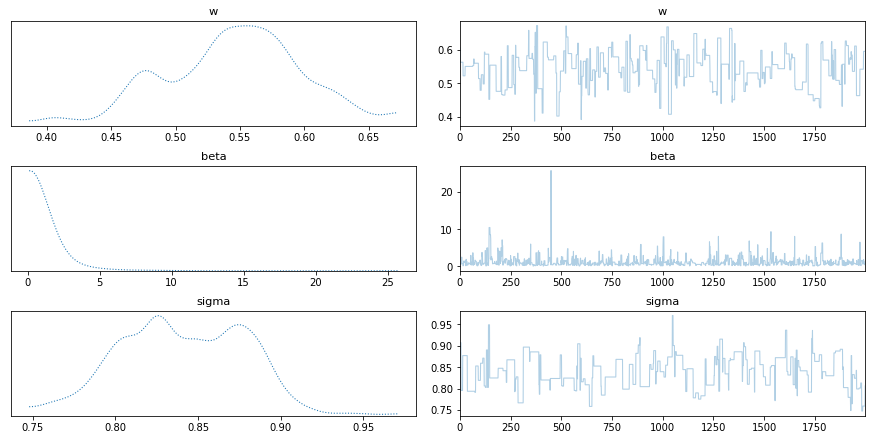

In [5]:
def bayesian_lasso(X_train, y_train, X_test, y_test):
    """function to train bayesian model
        Parameters
        ----------
        X_train : np.ndarray()
            array of training features
        y_train: np.ndarray()
            array of training target
        X_test: np.ndarray()
            array of testing features
        y_test: np.ndarray()
            array of testing target
            
        Returns
        ----------
        model: pymc3.model.Model()
            model instance from pymc3
        y_bayes_pred: np.ndarray()
            mean of posterior predictions from the bayesian model
        y_bayes_pred_train: np.ndarray()
            mean of posterior predictions from the bayesian model on training set
        y_bayes_dist_pred: np.ndarray()
            distribution of posterior
        y_bayes_dist_pred_train: np.ndarray()
            distribution of posterior for training set
    """
    model = pm.Model()
    with model:
        beta = pm.HalfCauchy('beta', beta = 1)
        w = pm.Laplace('w', mu=0., b=beta, shape = X_train.shape[1])
            
        sigma = pm.HalfCauchy('sigma', beta = 1)
        y_obs = pm.Normal('y', mu=tt.dot(X_train,w), sd=sigma, observed=y_train.squeeze())
        
    with model:
        # obtain starting values via MAP
        #start = find_MAP(fmin=optimize.fmin_powell)
        # instantiate sampler
        #step = NUTS(scaling=start)
        step = pm.Metropolis()
        # draw 2000 posterior samples
        trace = sample(2000, step, chains=1)
    
    pm.traceplot(trace, combined=True)
    
    y_bayes_pred = X_test.dot(np.mean(trace['w'], axis=0).T)
    y_bayes_pred_train = X_train.dot(np.mean(trace['w'], axis=0).T)
    y_bayes_dist_pred = X_test.dot(trace['w'].T)
    y_bayes_dist_pred_train = X_train.dot(trace['w'].T)

    # The coefficients
    print('Coefficients: \n', np.mean(trace['w'], axis=0))
    # The mean squared error
    print('Mean squared testing error: %.2f'% mean_squared_error(y_test, y_bayes_pred))
    print('Mean squared training error: %.2f'% mean_squared_error(y_train, y_bayes_pred_train))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.2f'% r2_score(y_test, y_bayes_pred))
        
    return model, y_bayes_pred, y_bayes_pred_train, y_bayes_dist_pred, y_bayes_dist_pred_train, trace

model, y_bayes_pred, y_bayes_pred_train, y_bayes_dist_pred, y_bayes_dist_pred_train, trace  = bayesian_lasso(X_train, y_train, X_test, y_test)

In [6]:
def get_unscaled_error(y_test, y_pred, y_bayes_pred, y_bayes_dist_pred):
    """ function to get unscaled errors
        Parameters
        ----------
        y_test : np.ndarray()
            array of testing target
        y_pred: np.ndarray()
            array of testing predictions
        y_bayes_pred: np.ndarray()
            mean of posterior predictions from the bayesian model
        y_bayes_dist_pred: np.ndarray()
            posterior predictions from the bayesian model
            
        Returns
        ----------
        scaled_y_pred : np.ndarray()
            scaled array of predictions
        scaled_y_bayes_pred: np.ndarray()
            scaled mean of posterior predictions from the bayesian model
        scaled_y_bayes_dist_pred: np.ndarray()
            scaled distribution of posterior
        scaled_y_test: np.ndarray()
            scaled target
    """
    
    mean_y = np.mean(y[:-testing_size])
    std_y = np.std(y[:-testing_size])
    
    scaled_y_pred = [(i * std_y) + mean_y for i in y_pred]
    scaled_y_bayes_pred = [(i * std_y) + mean_y for i in y_bayes_pred]
    scaled_y_test = [(i * std_y) + mean_y for i in y_test]
    scaled_y_bayes_dist_pred = [(i * std_y) + mean_y for i in y_bayes_dist_pred]
    
    print('Scaled Mean squared error of lasso : %.2f'% mean_squared_error(scaled_y_test, scaled_y_pred))
    print('Scaled Mean squared error of bayes: %.2f'% mean_squared_error(scaled_y_test, scaled_y_bayes_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination of scaled bayes predictions: %.2f'% r2_score(scaled_y_test, scaled_y_bayes_pred))
    
    return scaled_y_pred, scaled_y_bayes_pred, scaled_y_bayes_dist_pred, scaled_y_test
    
print("Testing Errors \n")
scaled_y_pred, scaled_y_bayes_pred, scaled_y_bayes_dist_pred, scaled_y_test = get_unscaled_error(y_test, y_pred, y_bayes_pred, y_bayes_dist_pred)
print("\n Training Errors \n")
_, _, _, _, = get_unscaled_error(y_train, y_pred_train, y_bayes_pred_train, y_bayes_dist_pred_train)


Testing Errors 

Scaled Mean squared error of lasso : 3845.43
Scaled Mean squared error of bayes: 3848.49
Coefficient of determination of scaled bayes predictions: 0.38

 Training Errors 

Scaled Mean squared error of lasso : 3930.92
Scaled Mean squared error of bayes: 3931.26
Coefficient of determination of scaled bayes predictions: 0.30


printing data and lasso graphs for results 



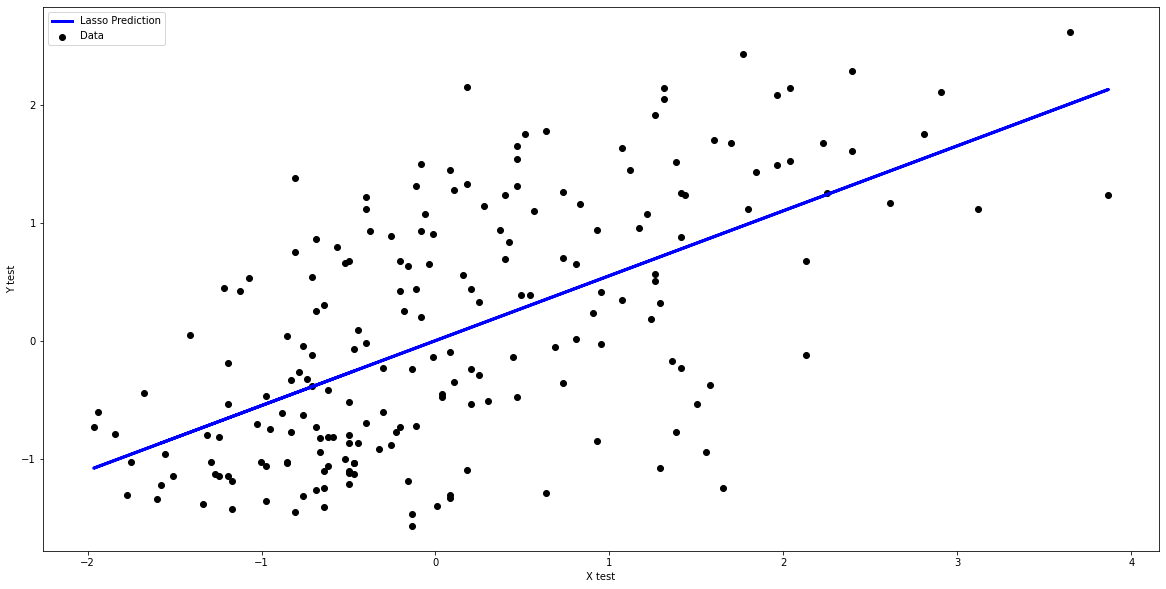

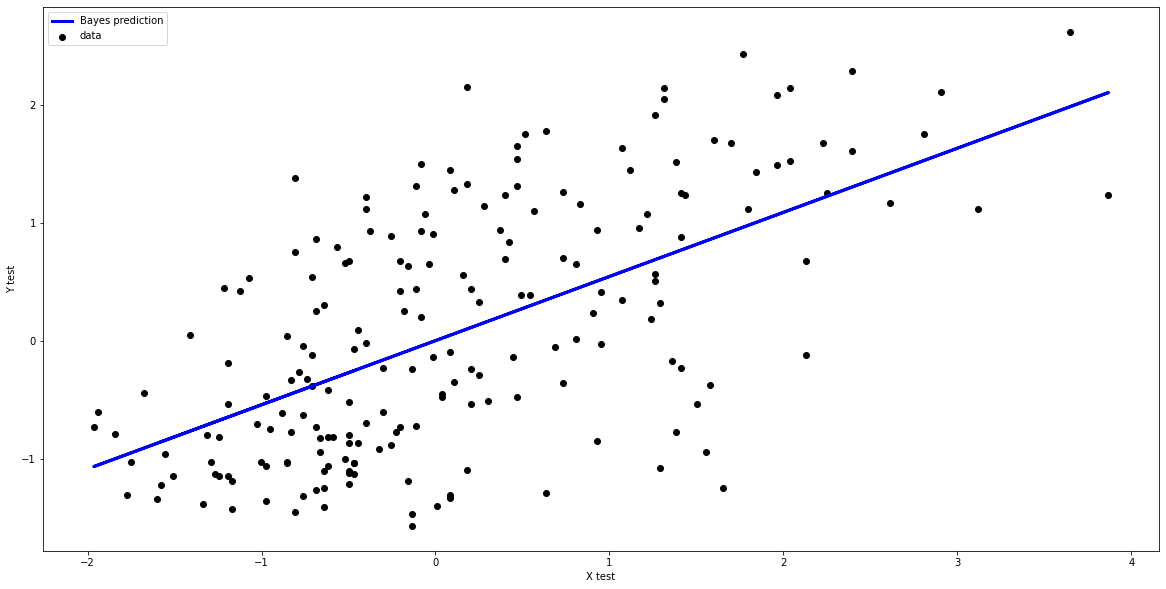


 printing mse error graphs for results scaled back for lasso versus bayes 



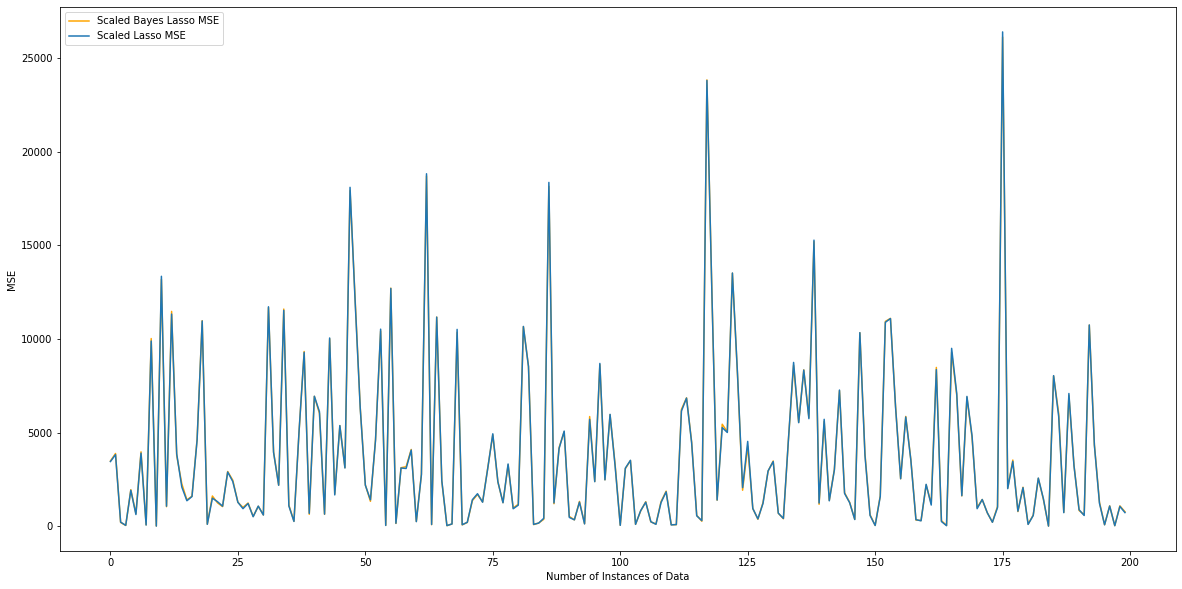

In [7]:
def plot_output(y_test, y_pred, y_bayes, X_test=X_test, plot_unscaled=True):
    """function to plot output
        Parameters
        ----------
        y_test: np.ndarray()
            array of testing target
        y_pred: np.ndarray()
            array of predictions
        y_bayes_dist_pred: np.ndarray()
            distribution of posterior
         X_test : np.ndarray()
            array of testing features
        plot_unscaled: Boolean
            boolean flag to plot unscaled features
            
        Returns
        ----------
        
    """
    if(plot_unscaled == True):
    # Plot outputs
        plt.figure(figsize=(20,10))
        plt.scatter(X_test, y_test,  color='black', label='Data')
        plt.plot(X_test, y_pred, color='blue', linewidth=3, label='Lasso Prediction')
        plt.legend(loc="upper left")
        plt.xlabel('X test')
        plt.ylabel('Y test')
        plt.show()
        
        plt.figure(figsize=(20,10))
        plt.scatter(X_test, y_test,  color='black',label='data')
        plt.plot(X_test, y_bayes, color='blue', linewidth=3, label='Bayes prediction')
        plt.legend(loc="upper left")
        plt.xlabel('X test')
        plt.ylabel('Y test')
        plt.show()
    else:
        plt.figure(figsize=(20,10))
        plt.plot([(x-y)**2 for x, y in zip(y_test, y_bayes)],color='orange', label='Scaled Bayes Lasso MSE');
        plt.plot([(x-y)**2 for x, y in zip(y_test, y_pred)],label='Scaled Lasso MSE');
        plt.legend(loc="upper left")
        plt.xlabel('Number of Instances of Data')
        plt.ylabel('MSE')
        plt.savefig('mse_plot_bayesian.png')
        plt.show()
    
print("printing data and lasso graphs for results \n")
plot_output(y_test, y_pred, y_bayes_pred, X_test, True)
print("\n printing mse error graphs for results scaled back for lasso versus bayes \n")
plot_output(scaled_y_test, scaled_y_pred, scaled_y_bayes_pred, X_test, False)
# print("\n printing mse error graphs for results scaled back for lasso versus bayes distribution \n")
# plot_output(scaled_y_test, scaled_y_pred, scaled_y_bayes_pred, X_test, False)

Plotting training predictions 



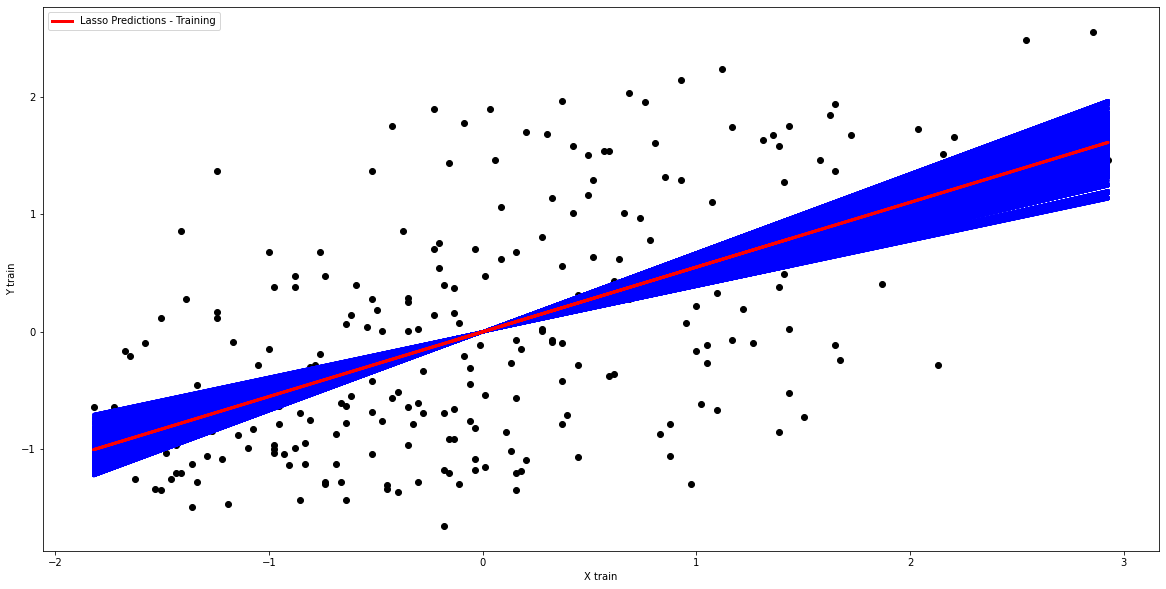


Plotting testing predictions 



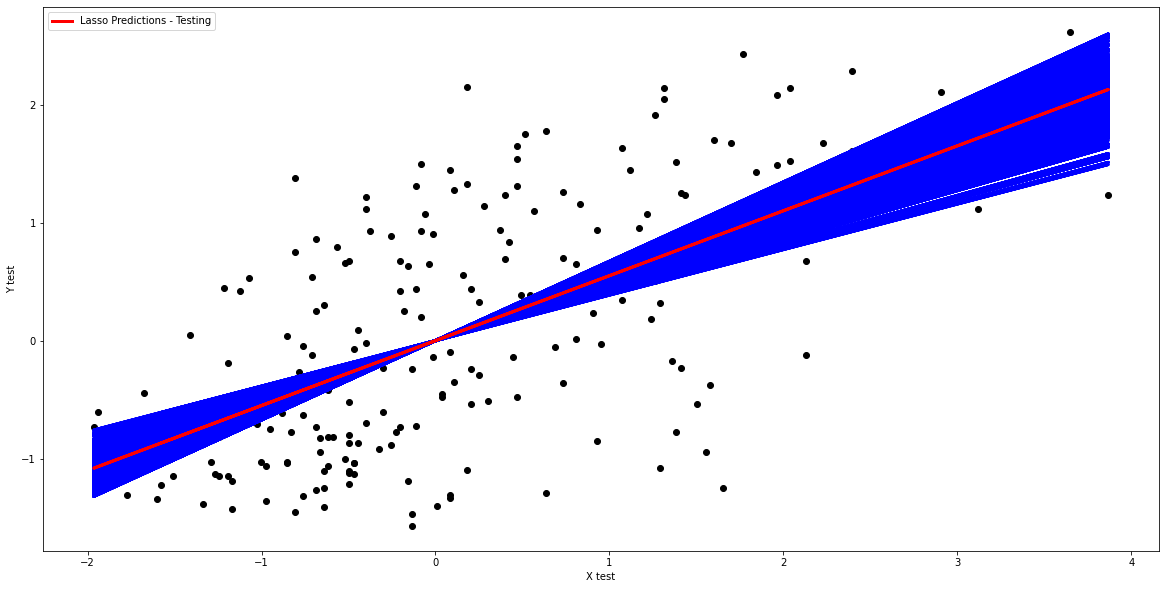

In [8]:
def plot_train_test_error(X, y, y_pred, y_bayes_dist_pred, trace, lasso, train_error=False):
    """function to plot output
        Parameters
        ----------
        X: np.ndarray()
            training/testing features
        y: np.ndarray()
            training/testing target
        y_pred: np.ndarray()
            prediction from frequentist lasso
        y_bayes_dist_pred: np.ndarray()
            distribution of posterior
        trace : pymc3.backends.base.MultiTrace
            trace object of the bayesian model
        lasso: sklearn.linear_model.coordinate_descent.Lasso
            learned model instance
        train_error: Boolean
            boolean flag for printing training/testing error
            
        Returns
        ----------
        
    """
    if(train_error == True):
        #plot training
        plt.figure(figsize=(20,10))
        plt.scatter(X, y,  color='black');
        plt.plot(X, X.dot(trace['w'].T), color='blue', linewidth=3);
        plt.plot(X, lasso.predict(X), color='red', linewidth=3, label='Lasso Predictions - Training');
        plt.xlabel('X train')
        plt.ylabel('Y train')
        plt.legend(loc="upper left")
        plt.show()
    else:
        # Plot outputs
        plt.figure(figsize=(20,10))
        plt.scatter(X, y,  color='black');
        plt.plot(X, y_bayes_dist_pred, color='blue', linewidth=3);
        plt.plot(X, y_pred, color='red', linewidth=3, label='Lasso Predictions - Testing');
        plt.xlabel('X test')
        plt.ylabel('Y test')
        plt.legend(loc="upper left")
        plt.show()
        
print("Plotting training predictions \n")
plot_train_test_error(X_train, y_train, y_pred, y_bayes_dist_pred, trace, lasso, train_error=True)
print("\nPlotting testing predictions \n")
plot_train_test_error(X_test, y_test, y_pred, y_bayes_dist_pred, trace, lasso, train_error=False)